In [1]:
import pylab as plt
import numpy as np
import pandas as pd
from astroquery.gaia import Gaia

from astropy.table import Table
import astropy.coordinates as ac
_ = ac.galactocentric_frame_defaults.set('v4.0') #set the default Astropy Galactocentric frame parameters to the values adopted in Astropy v4.0
import astropy.units as u
from astropy.io import fits

import scipy.stats as stats

In [2]:
fgkm_master = pd.read_csv("data/fgkm_master.csv")
fgkm_master

,source_id,ra,dec,l,b,pm,pmra,pmra_error,pmdec,pmdec_error,...,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z
0,8044474553216,44.927666,0.219128,176.645475,-48.802311,14.712925,11.987892,0.033959,-8.529984,0.025886,...,17.77345,15.74187,14.89205,15.225330,14.48534,0.015836,0.014353,0.012603,0.002154,0.020897
1,12545600306304,45.234476,0.318152,176.860886,-48.513020,48.337337,0.056719,0.020818,-48.337303,0.015860,...,14.51712,12.78380,12.15883,11.947370,11.84606,0.029319,0.000382,0.000311,0.000315,0.013419
2,14401026146688,45.047858,0.295074,176.689759,-48.663170,6.636381,6.281287,0.034993,2.141725,0.025406,...,17.25891,15.50362,14.87164,15.230740,14.49686,0.014295,0.014339,0.012604,0.002173,0.020892
3,15637976759168,45.194622,0.344149,176.790851,-48.523609,1.950195,1.941703,0.015542,-0.181805,0.013826,...,15.11456,13.67059,14.77194,17.000500,12.86236,0.022253,0.002956,0.005737,0.095059,0.020055
4,16531329957376,45.141363,0.359598,176.718137,-48.551124,89.935150,-53.789714,0.024427,-72.076330,0.016337,...,12.01004,10.47343,10.01602,9.884631,10.04061,0.000699,0.000130,0.000115,0.000141,0.000320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3273036,6917508003777163904,315.132676,-0.285956,48.717997,-28.521277,22.378012,20.849992,0.029277,8.127312,0.017501,...,16.80885,14.87231,14.24822,14.764940,13.77120,0.012253,0.009378,0.001016,0.002266,0.013753
3273037,6917508038136902016,315.147027,-0.278247,48.733944,-28.529586,21.632872,-3.938550,0.030909,-21.271317,0.019352,...,17.05069,15.24693,14.60410,14.417840,14.32157,0.012651,0.009405,0.007891,0.009961,0.013831
3273038,6917511371031526272,315.169686,-0.165559,48.857057,-28.490746,11.508323,-10.953868,0.044485,3.529058,0.027088,...,18.48001,16.21760,15.25354,14.940000,14.78112,0.019448,0.010752,0.014372,0.013018,0.016123
3273039,6917517865022020736,314.715243,-0.254421,48.504216,-28.147333,14.606207,14.288730,0.018689,3.028776,0.013359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
ra = np.array(fgkm_master['ra'])
dec = np.array(fgkm_master['dec'])
dist = np.array(fgkm_master['r_med_photogeo'])/1000 # kpc; Is correct take photogeo as distance?
pmra = np.array(fgkm_master['pmra'])
pmdec = np.array(fgkm_master['pmdec'])
rv = np.array(fgkm_master['radial_velocity'])

In [4]:
# Transforming heliocentric frame to galactocentric frame
# Obs: rv values that originally were set zero are not correct

# ra = fgkm_master['ra']
# dec = fgkm_master['dec']
# d = fgkm_master['r_med_photogeo']/1000 # kpc; Is correct take photogeo as distance?
# pmra = fgkm_master['pmra']
# pmdec = fgkm_master['pmdec']
# rv = fgkm_master['radial_velocity']

c_ecu = ac.ICRS(ra=ra*u.degree, dec=dec*u.degree, distance=dist*u.kpc, pm_ra_cosdec=pmra*u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr, radial_velocity=rv*u.km/u.s)

c_gal = c_ecu.transform_to(ac.Galactic())

In [5]:
#Caculate cartesians galactocentric coord
# X: galactic center to Earth
# Y: perpendicular to X and Z
# Z: Earth to north galactic pole

Rsol = 8 #kpc (adopted distance to Galacitc center from Eisenhauer+2003 (7.94 +- 0.42 kpc)

X = Rsol - dist*np.cos(np.radians(fgkm_master.l))*np.cos(np.radians(fgkm_master.b))
Y = -dist*np.sin(np.radians(fgkm_master.l))*np.cos(np.radians(fgkm_master.b))
Z = dist*np.sin(np.radians(fgkm_master.b))

R = np.sqrt(X**2 + Y**2)
phi = np.arctan(Y/X) # radians

In [6]:
# Change frame from equatorial to galactic

A_v = 4.74 # mu/(mas yr^-1) D/kpc km/s
v_l = A_v*dist*c_gal.pm_l_cosb.value
v_b = A_v*dist*c_gal.pm_b.value

v_rad = c_gal.radial_velocity.value

#Calculate cartesians galactocentric velocities

vX_obs = -v_rad*np.cos(np.radians(fgkm_master.l))*np.cos(np.radians(fgkm_master.b)) \
+ v_b * np.cos(np.radians(fgkm_master.l)) * np.sin(np.radians(fgkm_master.b)) \
+ v_l*np.sin(np.radians(fgkm_master.l))

vY_obs = -v_rad*np.sin(np.radians(fgkm_master.l))*np.cos(np.radians(fgkm_master.b)) \
+ v_b * np.sin(np.radians(fgkm_master.l)) * np.sin(np.radians(fgkm_master.b)) \
- v_l*np.cos(np.radians(fgkm_master.l))

vZ_obs = v_rad * np.sin(np.radians(fgkm_master.b)) + v_b * np.cos(np.radians(fgkm_master.b))

In [7]:
# Correct galactocentric velocities for solar motion
# Dehnen & Binney 1998, also see Hogg et al. 2005
vX_sun = -10 #km/s #−10.0+-0.4 km/s
v_LSR = 220 #km/s
vY_sun = -5 #km/s #−5.3+-0.6 km/s
vZ_sun = 7 #km/s #7.2+-0.4 km/s


v_X = vX_obs + vX_sun
v_Y = vY_obs - v_LSR + vY_sun
v_Z = vZ_obs + vZ_sun

In [8]:
# Cylindrical coordinate 

v_R = v_X*X/R + v_Y*Y/R
v_phi = -v_X*Y/R + v_Y*X/R

#Obs: retrograde rotation is indicated by vφ > 0.
#Stars with vR > 0 move away from the Galactic center, and
#stars with vZ > 0 move toward the North Galactic Pole.

#### Figure 5 Reproduction

In [9]:
#Transform g-r sdss color to G-Grp gaia color --> Jester et al. (2005), Table 5
a, b, c, d, sigma = 0.2391, 0.8250, -0.1815, 0.0150, 0.07
gr_sdss_min, gr_sdss_max = 0.2, 0.4
gr_gaia_min = a + b*gr_sdss_min + c*gr_sdss_min**2 + d*gr_sdss_min**3
gr_gaia_max = a + b*gr_sdss_max + c*gr_sdss_max**2 + d*gr_sdss_max**3
print('gr_gaia_min:',gr_gaia_min)
print('gr_gaia_max:',gr_gaia_max)

gr_gaia_min: 0.39696000000000004
gr_gaia_max: 0.5410200000000001


In [10]:
fgkm_master["sdss_gr"] = fgkm_master["psfmag_g"] - fgkm_master["psfmag_r"]
# g_rp is Gaia color, sdss_gr is SDSS color

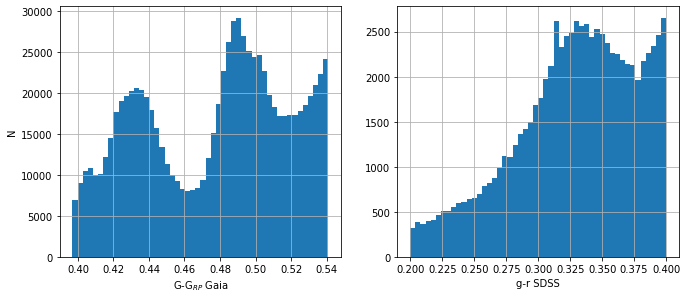

In [11]:
#Colors g-r hist Gaia vs SDSS
fig=plt.figure(1,figsize=(10,4))
fig.subplots_adjust(wspace=0.2,hspace=0.34,top=0.97,bottom=0.1,left=0.09,right=0.95)

ax=fig.add_subplot(121)
ax.hist(fgkm_master.g_rp, bins=50, range=(gr_gaia_min,gr_gaia_max))
ax.grid()
ax.set_ylabel('N')
ax.set_xlabel('G-G$_{RP}$ Gaia')

ax=fig.add_subplot(122)
ax.hist(fgkm_master.sdss_gr, bins=50, range=(gr_sdss_min,gr_sdss_max))
ax.grid()
# ax.set_ylabel('N')
ax.set_xlabel('g-r SDSS');

Text(0.5, 0, 'Metalicity')

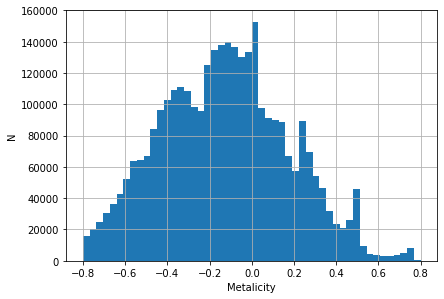

In [12]:
#Metalicity --> -0.8<FeH<0.8, golden sample?
fig=plt.figure(1,figsize=(6,4))
fig.subplots_adjust(wspace=0.2,hspace=0.34,top=0.97,bottom=0.1,left=0.09,right=0.95)

ax=fig.add_subplot(111)
ax.hist(fgkm_master.mh_gspphot, bins=50)#, range=(gr_gaia_min,gr_gaia_max))
ax.grid()
ax.set_ylabel('N')
ax.set_xlabel('Metalicity')

6647.465


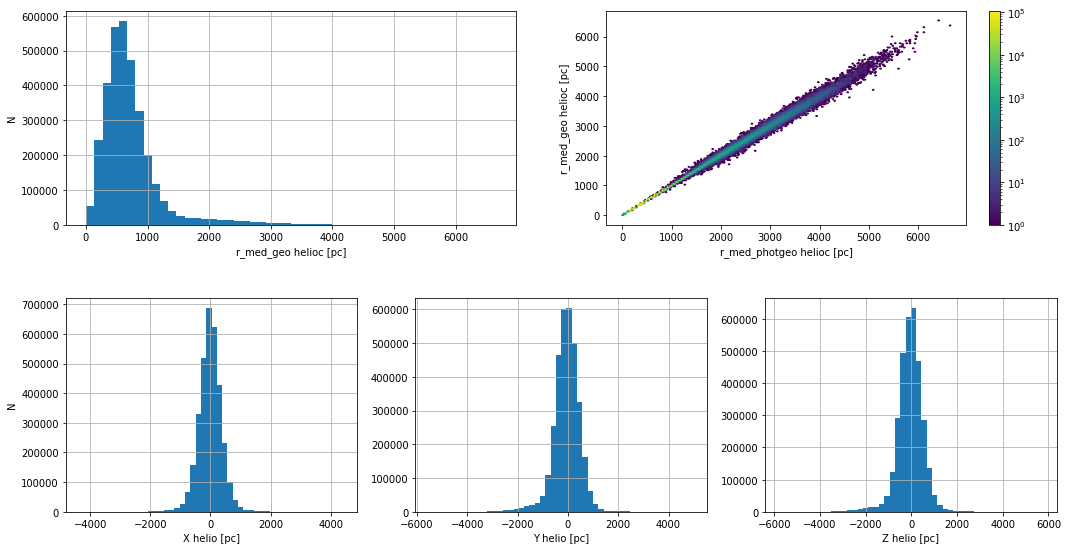

In [13]:
#Distances helioc
fig=plt.figure(1,figsize=(16,8))
fig.subplots_adjust(wspace=0.2,hspace=0.34,top=0.97,bottom=0.1,left=0.09,right=0.95)

ax=fig.add_subplot(221)
ax.hist(fgkm_master.r_med_photogeo, bins=50)
ax.grid()
ax.set_ylabel('N')
ax.set_xlabel('r_med_geo helioc [pc]')

ax=fig.add_subplot(222)
# ax.hist(fgkm_master.r_med_photogeo, bins=50)
# ax.grid()
# # ax.set_ylabel('N')
# ax.set_xlabel('r med photgeo [pc]')
bla = ax.hexbin(fgkm_master.r_med_photogeo, fgkm_master.r_med_geo, gridsize=200, bins='log', cmap='viridis')
fig.colorbar(bla)
ax.set_ylabel('r_med_geo helioc [pc]')
ax.set_xlabel('r_med_photgeo helioc [pc]')


ax=fig.add_subplot(234)
ax.hist(c_ecu.cartesian.x.value*1000, bins=50)
ax.grid()
ax.set_ylabel('N')
ax.set_xlabel('X helio [pc]')

ax=fig.add_subplot(235)
ax.hist(c_ecu.cartesian.y.value*1000, bins=50)
ax.grid()
# ax.set_ylabel('N')
ax.set_xlabel('Y helio [pc]')

ax=fig.add_subplot(236)
ax.hist(c_ecu.cartesian.z.value*1000, bins=50)
ax.grid()
# ax.set_ylabel('N')
ax.set_xlabel('Z helio [pc]')


print(fgkm_master.r_med_photogeo.max())

Text(0.5, 0, 'R [kpc]')

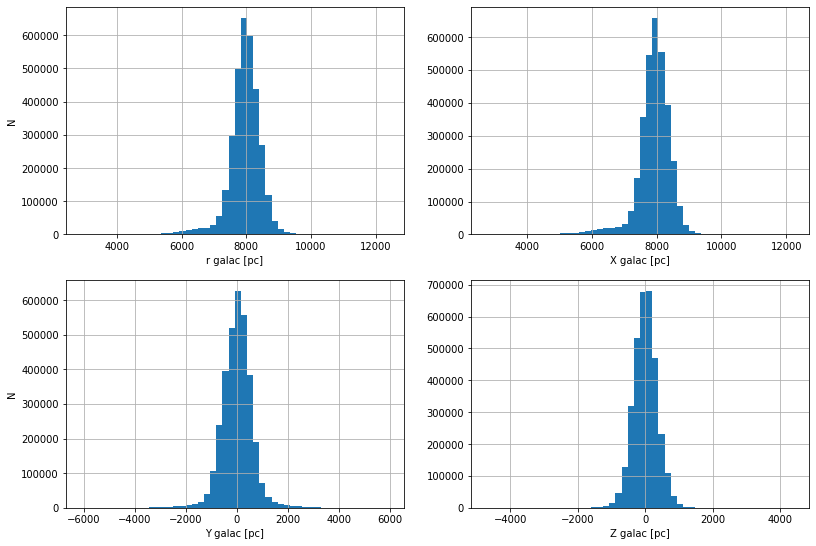

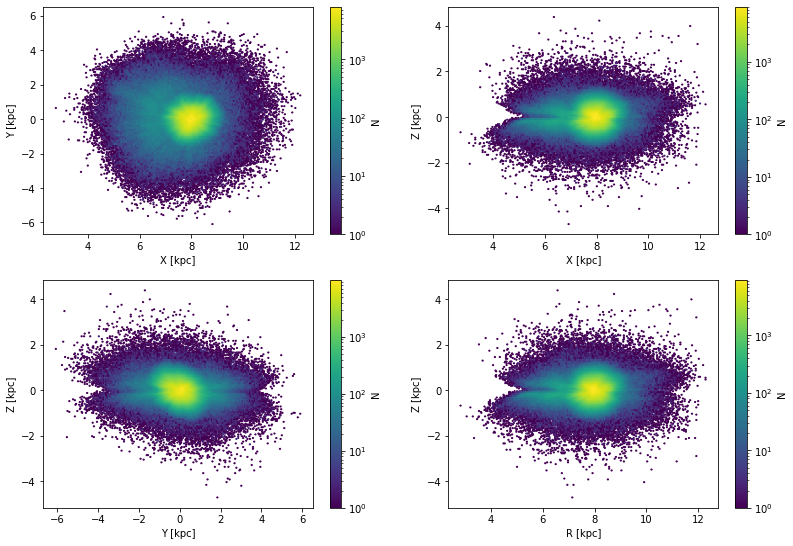

In [14]:
fig=plt.figure(1,figsize=(12,8))
fig.subplots_adjust(wspace=0.2,hspace=0.2,top=0.97,bottom=0.1,left=0.09,right=0.95)

ax=fig.add_subplot(221)
ax.hist((np.sqrt(X**2+Y**2+Z**2)*1000), bins=50)
ax.grid()
ax.set_ylabel('N')
ax.set_xlabel('r galac [pc]')

ax=fig.add_subplot(222)
ax.hist(X*1000, bins=50)
ax.grid()
# ax.set_ylabel('N')
ax.set_xlabel('X galac [pc]')

ax=fig.add_subplot(223)
ax.hist(Y*1000, bins=50)
ax.grid()
ax.set_ylabel('N')
ax.set_xlabel('Y galac [pc]')

ax=fig.add_subplot(224)
ax.hist(Z*1000, bins=50)
ax.grid()
# ax.set_ylabel('N')
ax.set_xlabel('Z galac [pc]')


fig2=plt.figure(2,figsize=(12,8))
fig2.subplots_adjust(wspace=0.2,hspace=0.2,top=0.97,bottom=0.1,left=0.09,right=0.95)

ax2=fig2.add_subplot(221)
bla = ax2.hexbin(X, Y, gridsize=200, bins='log', cmap='viridis')
cb = fig2.colorbar(bla)
cb.set_label('N')
ax2.set_ylabel('Y [kpc]')
ax2.set_xlabel('X [kpc]')

ax2=fig2.add_subplot(222)
bla = ax2.hexbin(X, Z, gridsize=200, bins='log', cmap='viridis')
cb = fig2.colorbar(bla)
cb.set_label('N')
ax2.set_ylabel('Z [kpc]')
ax2.set_xlabel('X [kpc]')

ax2=fig2.add_subplot(223)
bla = ax2.hexbin(Y, Z, gridsize=200, bins='log', cmap='viridis')
cb = fig2.colorbar(bla)
cb.set_label('N')
ax2.set_ylabel('Z [kpc]')
ax2.set_xlabel('Y [kpc]')

ax2=fig2.add_subplot(224)
bla = ax2.hexbin(np.sqrt(X**2+Y**2), Z, gridsize=200, bins='log', cmap='viridis')
cb = fig2.colorbar(bla)
cb.set_label('N')
ax2.set_ylabel('Z [kpc]')
ax2.set_xlabel('R [kpc]')

(-300.0, -100.0)

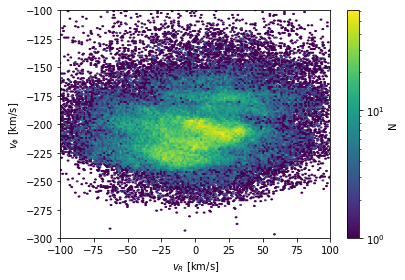

In [15]:
#vr nan
mask_rv = fgkm_master['radial_velocity_error']==-99.
mask_plot = ~mask_rv & (np.sqrt((X-8)**2+Y**2+Z**2)<.2) # & (Z>.05) & (Z<0.1) & (fgkm_master.b>80)

fig2=plt.figure(2,figsize=(12,8))
fig2.subplots_adjust(wspace=0.2,hspace=0.2,top=0.97,bottom=0.1,left=0.09,right=0.95)

ax2=fig2.add_subplot(221)
bla = ax2.hexbin(v_R[mask_plot], v_phi[mask_plot], gridsize=500, bins='log', cmap='viridis')
cb = fig2.colorbar(bla)
cb.set_label('N')
ax2.set_xlabel('$v_R$ [km/s]')
ax2.set_ylabel('$v_\phi$ [km/s]')
ax2.set_xlim(-100,100)
ax2.set_ylim(-300,-100)

# ax2=fig2.add_subplot(222)


In [16]:
# High metallicity
mask_hm = (fgkm_master["b"] > 80) & \
            (fgkm_master["mh_gspphot"] > -0.9)
            #(fgkm_master["g_rp"] > gr_gaia_min) & \
            #(fgkm_master["g_rp"] < gr_gaia_max) & \

# Low metallicity
mask_lm = (fgkm_master["b"] > 80) & \
            (fgkm_master["g_rp"] > gr_gaia_min) & \
            (fgkm_master["g_rp"] < gr_gaia_max) & \
            (fgkm_master["mh_gspphot"] < -1.1)

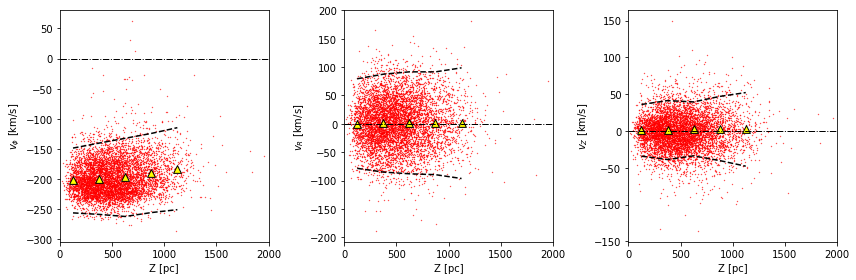

In [17]:
fig=plt.figure(1,figsize=(12,4))
fig.subplots_adjust(wspace=0.2,hspace=0.2,top=0.97,bottom=0.1,left=0.09,right=0.95)

median = stats.binned_statistic(Z[mask_hm]*1000, v_phi[mask_hm], statistic='mean', bins=np.arange(0, 1500, 250))
std = stats.binned_statistic(Z[mask_hm]*1000, v_phi[mask_hm], statistic="std", bins=np.arange(0, 1500, 250))

ax=fig.add_subplot(131)
ax.hlines(y=0, xmin=0, xmax=max(Z[mask_hm])*1000, linestyles='dashdot', colors='black', lw=1) 
ax.scatter(Z[mask_hm & ~mask_rv]*1000, v_phi[mask_hm & ~mask_rv],c="red", s=.1)
ax.scatter(median.bin_edges[:-1]+(median.bin_edges[1]- median.bin_edges[0])/2, median.statistic, marker='^', color="yellow", edgecolor='black', s=60)
ax.plot(median.bin_edges[:-1]+(median.bin_edges[1]- median.bin_edges[0])/2, median.statistic+2*std.statistic, ls='dashed', color="black")
ax.plot(median.bin_edges[:-1]+(median.bin_edges[1]- median.bin_edges[0])/2, median.statistic-2*std.statistic, ls='dashed', color="black")
ax.set_ylabel('$v_{\phi}$ [km/s]')
ax.set_xlabel('Z [pc]')
ax.set_xlim(0,2000)#max(Z[mask_hm & ~mask_rv])*1000)


median = stats.binned_statistic(Z[mask_hm]*1000, v_R[mask_hm], statistic='mean', bins=np.arange(0, 1500, 250))
std = stats.binned_statistic(Z[mask_hm]*1000, v_R[mask_hm], statistic="std", bins=np.arange(0, 1500, 250))

ax=fig.add_subplot(132)
ax.hlines(y=0, xmin=0, xmax=max(Z[mask_hm])*1000, linestyles='dashdot', colors='black', lw=1) 
ax.scatter(Z[mask_hm & ~mask_rv]*1000, v_R[mask_hm & ~mask_rv],c="red", s=.1)
ax.scatter(median.bin_edges[:-1]+(median.bin_edges[1]- median.bin_edges[0])/2, median.statistic, marker='^', color="yellow", edgecolor='black',s=60)
ax.plot(median.bin_edges[:-1]+(median.bin_edges[1]- median.bin_edges[0])/2, median.statistic+2*std.statistic, ls='dashed', color="black")
ax.plot(median.bin_edges[:-1]+(median.bin_edges[1]- median.bin_edges[0])/2, median.statistic-2*std.statistic, ls='dashed', color="black")
ax.set_ylabel('$v_R$ [km/s]')
ax.set_xlabel('Z [pc]')
ax.set_xlim(0,2000)#max(Z[mask_hm & ~mask_rv])*1000)


median = stats.binned_statistic(Z[mask_hm]*1000, v_Z[mask_hm], statistic='mean', bins=np.arange(0, 1500, 250))
std = stats.binned_statistic(Z[mask_hm]*1000, v_Z[mask_hm], statistic="std", bins=np.arange(0, 1500, 250))

ax=fig.add_subplot(133)
ax.hlines(y=0, xmin=0, xmax=max(Z[mask_hm])*1000, linestyles='dashdot', colors='black', lw=1) 
ax.scatter(Z[mask_hm & ~mask_rv]*1000, v_Z[mask_hm & ~mask_rv],c="red", s=.1)
ax.scatter(median.bin_edges[:-1]+(median.bin_edges[1]- median.bin_edges[0])/2, median.statistic, marker='^', color="yellow", edgecolor='black', s=60)
ax.plot(median.bin_edges[:-1]+(median.bin_edges[1]- median.bin_edges[0])/2, median.statistic+2*std.statistic, ls='dashed', color="black")
ax.plot(median.bin_edges[:-1]+(median.bin_edges[1]- median.bin_edges[0])/2, median.statistic-2*std.statistic, ls='dashed', color="black")
ax.set_ylabel('$v_Z$ [km/s]')
ax.set_xlabel('Z [pc]')
ax.set_xlim(0,2000)#max(Z[mask_hm & ~mask_rv])*1000)
plt.tight_layout()

---

In [18]:
# Setting up the data columns for use. 
lum = fgkm_master['lum_flame']
Teff = fgkm_master['teff_gspphot']
logL = np.log10(lum)
FeH = fgkm_master['mh_gspphot']
age = fgkm_master['age_flame']
red = fgkm_master['ebpminrp_gspphot']

In [19]:
fgkm_master.columns

Index(['source_id', 'ra', 'dec', 'l', 'b', 'pm', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'pmra_pmdec_corr', 'radial_velocity',
       'radial_velocity_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'bp_rp', 'g_rp', 'teff_gspphot', 'logg_gspphot',
       'mh_gspphot', 'ag_gspphot', 'ebpminrp_gspphot', 'alphafe_gspspec',
       'teff_gspspec', 'logg_gspspec', 'mh_gspspec', 'radius_flame',
       'lum_flame', 'mass_flame', 'age_flame', 'evolstage_flame',
       'radius_flame_spec', 'lum_flame_spec', 'mass_flame_spec',
       'age_flame_spec', 'evolstage_flame_spec', 'spectraltype_esphs',
       'r_med_geo', 'r_lo_geo', 'r_hi_geo', 'r_med_photogeo', 'r_lo_photogeo',
       'r_hi_photogeo', 'original_ext_source_id', 'psfmag_u', 'psfmag_g',
       'psfmag_r', 'psfmag_i', 'psfmag_z', 'psfmagerr_u', 'psfmagerr_g',
       'psfmagerr_r', 'psfmagerr_i', 'psfmagerr_z', 'sdss_gr'],
      dtype='object')

In [20]:
# Using AstroML binned statistics to set up color coding for N.
from astroML.stats import binned_statistic_2d

N, xedges, yedges = binned_statistic_2d(Teff[~Teff.isna() & ~logL.isna() & ~FeH.isna()], 
                                        logL[~Teff.isna() & ~logL.isna() & ~FeH.isna()], 
                                        FeH[~Teff.isna() & ~logL.isna() & ~FeH.isna()],
                                        'count', bins=200)

# Color coding for FeH. Gives a warning but still works in the plots.
FeH_mean, xedges, yedges = binned_statistic_2d(Teff[~Teff.isna() & ~logL.isna() & ~FeH.isna()], 
                                               logL[~Teff.isna() & ~logL.isna() & ~FeH.isna()], 
                                               FeH[~Teff.isna() & ~logL.isna() & ~FeH.isna()],
                                               'mean', bins=200)

# Color coding for reddening.
red_mean, xedges, yedges = binned_statistic_2d(Teff[~Teff.isna() & ~logL.isna() & ~red.isna()], 
                                               logL[~Teff.isna() & ~logL.isna() & ~red.isna()], 
                                               red[~Teff.isna() & ~logL.isna() & ~red.isna()],
                                               'mean', bins=200)

# Color coding for age.
age_mean, xedges, yedges = binned_statistic_2d(Teff[~Teff.isna() & ~logL.isna() & ~age.isna()], 
                                          logL[~Teff.isna() & ~logL.isna() & ~age.isna()], 
                                          age[~Teff.isna() & ~logL.isna() & ~age.isna()],
                                               'mean', bins=200)

In [21]:
# Choosing different color maps for the plots.
cmap = plt.get_cmap('viridis')
cmap2 = plt.get_cmap('seismic')
cmap3 = plt.get_cmap('Reds')
cmap4 = plt.get_cmap('gist_rainbow')

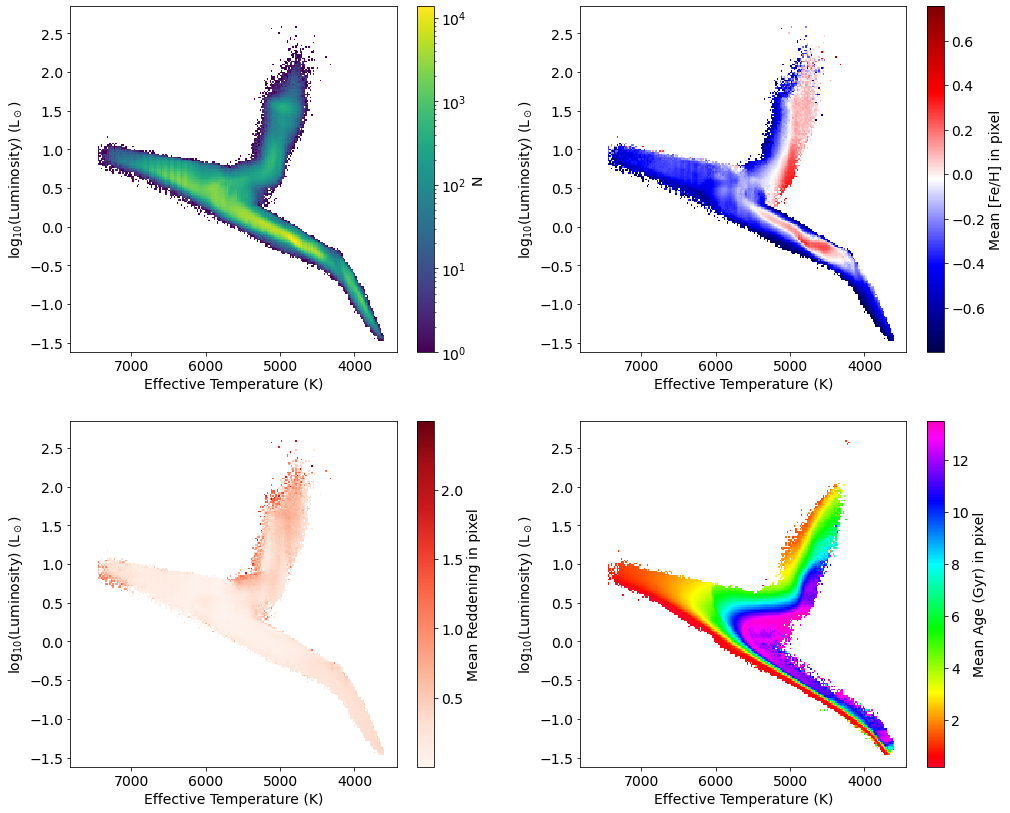

In [22]:
# Setting up plots for Figure 9, Panel 4 recreation.
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(wspace=0.25, left=0.1, right=0.95,
                    bottom=0.07, top=0.95)

plt.rcParams['font.size'] = 14


#------------------------------------------------------------
# Create first plot color coded by N. Gives an error, but the plot still works and looks like what we want.
plt.subplot(221)
plt.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', norm='log', interpolation='nearest', cmap=cmap)

plt.xlim(xedges[-1]*1.05, xedges[0]*0.95)
plt.ylim(yedges[0]*1.1, yedges[-1]*1.1)
plt.xlabel('Effective Temperature (K)')
plt.ylabel('log$_{10}$(Luminosity) (L$_\odot$)')

cb = plt.colorbar()#ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.0, 4.5],
                  #orientation='vertical')
cb.set_label('N')


#------------------------------------------------------------
# Create second plot color coded by FeH.
plt.subplot(222)
plt.imshow(FeH_mean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap2)

plt.xlim(xedges[-1]*1.05, xedges[0]*0.95)
plt.ylim(yedges[0]*1.1, yedges[-1]*1.1)
plt.xlabel('Effective Temperature (K)')
plt.ylabel('log$_{10}$(Luminosity) (L$_\odot$)')

cb = plt.colorbar()#ticks=[-.8, -.6, -.4, -.2, 0, .2, .4, .6, .8],
                  #format=r'$%.1f$', orientation='vertical')
cb.set_label('Mean [Fe/H] in pixel')


#------------------------------------------------------------
# Create third plot color coded by reddening.
plt.subplot(223)
plt.imshow(red_mean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap3)

plt.xlim(xedges[-1]*1.05, xedges[0]*0.95)
plt.ylim(yedges[0]*1.1, yedges[-1]*1.1)
plt.xlabel('Effective Temperature (K)')
plt.ylabel('log$_{10}$(Luminosity) (L$_\odot$)')

cb = plt.colorbar()#ticks=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5],
                  # format=r'$%.1f$', orientation='vertical')
cb.set_label('Mean Reddening in pixel')


#------------------------------------------------------------
# Create fourth plot color coded by age.
plt.subplot(224)
plt.imshow(age_mean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap4)

plt.xlim(xedges[-1]*1.05, xedges[0]*0.95)
plt.ylim(yedges[0]*1.1, yedges[-1]*1.1)
plt.xlabel('Effective Temperature (K)')
plt.ylabel('log$_{10}$(Luminosity) (L$_\odot$)')

cb = plt.colorbar()#ticks=[0, 2, 4, 6, 8, 10, 12, 14],
                  # orientation='vertical')
cb.set_label('Mean Age (Gyr) in pixel')